# FORESEE - Heavy Neutral Leptons (HNLs)

### Load Libraries 

In [1]:
import numpy as np
import sys
import os
import matplotlib.colors as mcolors
src_path = "/Users/alechewitt/Desktop/Git_felix/FORESEE"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model

from HeavyNeutralLepton import * 

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

HNL's are produced mainly via D and $B$ meson decay. To start, let us have a look at the $\text{D}^+$ spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi$, $\eta$, D, B, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. Let us show the $\text{D}^+$ spectrum obained by Pythia8. 

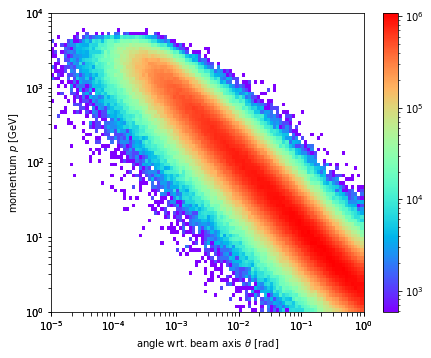

In [3]:
plot=foresee.get_spectrumplot(pid="411", generator="pythia8", energy="14",  prange=[[-5, 0, 100],[ 0, 4, 80]])
plot.show()

## 2. Specifying the Model: Heavy Neutral Leptons

In this notebook we consider Heavy Neutral Leptons (HNLs) $N$. These for example naturally arise in models with an addition right handed neutrinos. Their phenomenology is described by a the folling Lagrangian 

\begin{equation}
 \mathcal{L} = \bar N (i \gamma^\mu \partial_mu - \color{red}{m_N}) N - (g/\sqrt{2}) \color{red}{U_{\alpha}} W_\mu \bar \ell_\alpha \gamma^\mu N - (g/\sqrt{2} c_W) \color{red}{U_{\alpha}} Z_\mu \bar \nu_\alpha \gamma^\mu N 
\end{equation}

where $\color{red}{m_N}$ is the HNL mass, and $\color{red}{U_{\alpha}}$ are the mixings of the HNL with the SM neutrinos of flavour $\alpha=e,\mu, \tau$. For practical purposes, we will define $\color{red}{U_{\alpha}} = \color{red}{g} \times V_\alpha$ where $V_\alpha$ is fixed. In this case the HNL mass $\color{red}{m_N}$ and the coupling $\color{red}{g}$ are the free parameters of the model. 

Since the HNL model is rather complicted, we will use dedicated the `HeavyNeutralLepton` class, which will provide all properties of the model, eg their the *production rate*, the *lifetime* and their *decay branching fractions*. It will be initialized with the values of $V_\alpha$.

In [4]:
hnl = HeavyNeutralLepton(ve=.5, vmu=0, vtau=.2)

All properties are specified in the `Model` class. We initialize it with the name of the model as argument. 

In [5]:
energy = "14"
modelname="HNL"
model = Model(modelname, path="./")
allchannels = []

### a) HNL Production
As most LLPs, HNLs are produced in the decay of primary hadrons. Here we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. 

**Production via 2-body decays** HNLs can be produced in 2-body decays of the type $H^+ \to \ell N$. The corresponding branching fractions are given by  

\begin{equation}
    \text{BR}(H^+ \rightarrow \ell_{\alpha}^{+} N ) =   |U_{\alpha}|^2 \frac{G_F^2 M_H M_N^2 \tau_H f_H |V_H|^2 }{8 \pi}  \cdot \left[ 1- \frac{M_N^2}{M_H^2} + 2 \frac{M_{\ell}^2}{M_H^2}+ \frac{M_{\ell}^2}{M_N^2} \left( 1- \frac{M_{\ell}^2}{M_H^2} \right) \right] \times \left[\left(1+ \frac{M_N^2}{M_H^2}- \frac{M_{\ell}^2}{M_H^2}\right)^2 - 4 \frac{M_N^2}{M_H^2}\right]^{1/2}
\end{equation}

In particular we consider the decays:
- $D^\pm, D_s^\pm, B^\pm, B_c^\pm \to \ell^\pm N$

In [6]:
#colors for plots
import random
colors=list(mcolors.CSS4_COLORS)
length=len(colors)


thistle


In [7]:
channels = [
    [r'D^+ \to l^+ + N'    , '411', '-'],
    [r'D^- \to l^- + N'    ,'-411', '' ],
    [r'D_s^+ \to l^+ + N'  , '431', '-'],
    [r'D_s^- \to l^- + N'  ,'-431', '' ],
    [r'B^+ \to + l^+ + N'  , '521', '-'],
    [r'B^- \to + l^- + N'  ,'-521', '' ],
    [r'B_c^+ \to + l^+ + N', '541', '-'],
    [r'B_c^- \to + l^- + N','-541', '' ]
]
    
for label, pid_had, sign_lep in channels:
    for pid_lep in ["11","13","15"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        #print (r"added decay: "+label+" for l="+hnl.lepton[pid_lep])    
        label1 = "2body_" + pid_had + "_" + sign_lep+pid_lep
        print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_2bodydecay(
            label = label1,
            pid0 = pid_had,
            pid1 = pid_lep,
            br = hnl.get_2body_br(pid_had, sign_lep+pid_lep),
            generator = "Pythia8",
            energy = energy,
            nsample = 3,
        )
        allchannels.append(label1)

["2body_411_-11", "linen", r"$D^+ \to l^+ + N$"],
["2body_411_-15", "red", r"$D^+ \to l^+ + N$"],
["2body_-411_11", "chocolate", r"$D^- \to l^- + N$"],
["2body_-411_15", "tomato", r"$D^- \to l^- + N$"],
["2body_431_-11", "papayawhip", r"$D_s^+ \to l^+ + N$"],
["2body_431_-15", "red", r"$D_s^+ \to l^+ + N$"],
["2body_-431_11", "crimson", r"$D_s^- \to l^- + N$"],
["2body_-431_15", "tomato", r"$D_s^- \to l^- + N$"],
["2body_521_-11", "greenyellow", r"$B^+ \to + l^+ + N$"],
["2body_521_-15", "lightslategrey", r"$B^+ \to + l^+ + N$"],
["2body_-521_11", "yellowgreen", r"$B^- \to + l^- + N$"],
["2body_-521_15", "slateblue", r"$B^- \to + l^- + N$"],
["2body_541_-11", "lavender", r"$B_c^+ \to + l^+ + N$"],
["2body_541_-15", "lemonchiffon", r"$B_c^+ \to + l^+ + N$"],
["2body_-541_11", "plum", r"$B_c^- \to + l^- + N$"],
["2body_-541_15", "lemonchiffon", r"$B_c^- \to + l^- + N$"],


**Production via 2-body $\tau$ decays** HNLs can be produced in 2-body decays of the type $\tau \to H N$, the corresponding branching fraction is given by

\begin{aligned}
    \mathrm{Br}(\tau \rightarrow \mathrm{HN}) &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{16 \pi} G_F^2\left|V_H\right|^2 f_H^2 M_\tau^3 \cdot\left(\left(1-\frac{M_N^2}{M_\tau^2}\right)^2-\frac{M_H^2}{M_\tau^2}\left(1+\frac{M_N^2}{M_\tau^2}\right)\right) \\
    & \times \sqrt{\left(1-\frac{\left(M_H-M_N\right)^2}{M_\tau^2}\right)\left(1-\frac{\left(M_H+M_N\right)^2}{M_\tau^2}\right)}
\end{aligned}

or of the form $\tau \to \rho N$, in this case the branching fraction is given by

\begin{aligned}
    \mathrm{Br}(\tau \rightarrow \rho \mathrm{N}) &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{8 \pi} \frac{g_\rho^2}{M_\rho^2} G_F^2\left|V_{u d}\right|^2 M_\tau^3 \cdot\left(\left(1-\frac{M_N^2}{M_\tau^2}\right)^2+\frac{M_\rho^2}{M_\tau^2}\left(1+\frac{M_N^2-2 M_\rho^2}{M_\tau^2}\right)\right) \\
    & \times \sqrt{\left(1-\frac{\left(M_\rho-M_N\right)^2}{M_\tau^2}\right)\left(1-\frac{\left(M_\rho+M_N\right)^2}{M_\tau^2}\right)}
\end{aligned}

In particular we consider the decays:
- $\tau^{\pm} \to \pi^{\pm},K^{\pm}, \rho^{\pm} N$

In [8]:
#tau 2 body decays
#elements in channels have the form [decay label, parent particle pid, produced hadron pid (without sign), sign of produced hadron]
channels = [
[r'\tau^- \to \pi^- + N','15','211', '-' ],
[r'\tau^+ \to \pi^+ + N','15','211', ''  ],
[r'\tau^- \to K^- + N'  ,'15','321', '-' ],
[r'\tau^+ \to K^+ + N'  ,'15','321', ''  ],
[r'\tau^- \to \rho^- + N','15','213', '-'],
[r'\tau^+ \to \rho^+ + N','15','213', '' ]
]
    
for label, pid_tau, pid_had, sign_had in channels:
    for pid_tau in ["15"]:
        if hnl.vcoupling[pid_tau] <1e-9: continue
        label1 = "2body_tau_" + pid_tau + "_" + sign_had+pid_had
        print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_2bodydecay(
            label = label1,
            pid0 = pid_tau,
            pid1 = pid_had,
            br = hnl.get_2body_br_tau(pid_tau, sign_had+pid_had),
            generator = "Pythia8",
            energy = energy,
            nsample = 3,
        )
        allchannels.append(label1)

["2body_tau_15_-211", "yellowgreen", r"$\tau^- \to \pi^- + N$"],
["2body_tau_15_211", "blueviolet", r"$\tau^+ \to \pi^+ + N$"],
["2body_tau_15_-321", "peru", r"$\tau^- \to K^- + N$"],
["2body_tau_15_321", "tan", r"$\tau^+ \to K^+ + N$"],
["2body_tau_15_-213", "lightskyblue", r"$\tau^- \to \rho^- + N$"],
["2body_tau_15_213", "seashell", r"$\tau^+ \to \rho^+ + N$"],


**Production via 3-body decay to pseudoscalar meson** HNLs can also be produced in 3-body decays of the type $H \to H' \ell N$, where H' is a pseudoscalar. The corresponding branching fractions are given by  

\begin{aligned}
&\frac{d \mathrm{Br}\left(\mathrm{H} \rightarrow \mathrm{H}^{\prime} \mathrm{l}_\alpha^{+} \mathrm{N}\right)}{d E_N d q^2}=\tau_H \cdot\left|U_\alpha\right|^2 \cdot \frac{\left|V_{H H^{\prime}}\right|^2 G_F^2}{64 \pi^3 M_H^2} \left(f_{-}^2\left(q^2\right) \cdot\left(q^2\left(M_N^2+M_l^2\right)-\left(M_N^2-M_l^2\right)^2\right)\right. \\
&+2 f_{+}\left(q^2\right) f_{-}\left(q^2\right)\left(M_N^2\left(2 M_H^2-2 M_{H^{\prime}}^2-4 E_N M_H-M_l^2+M_N^2+q^2\right)+M_l^2\left(4 E_N M_H+M_l^2-M_N^2-q^2\right)\right) \\
& +f_{+}^2\left(q^2\right)\left(\left(4 E_N M_H+M_l^2-M_N^2-q^2\right)\left(2 M_H^2-2 M_{H^{\prime}}^2-4 E_N M_H-M_l^2+M_N^2+q^2\right)\right. \\
&\left.-\left(2 M_H^2+2 M_{H^{\prime}}^2-q^2\right)\left(q^2-M_N^2-M_l^2\right)\right)
\end{aligned}

where

\begin{aligned}
f_{+}\left(q^2\right) &=\frac{f_{+}(0)}{\left(1-q^2 / M_V^2\right)} \\
f_0\left(q^2\right) &=\frac{f_0(0)}{\left(1-q^2 / M_S^2\right)} \\
f_0\left(q^2\right)=f_{+}\left(q^2\right) &+\frac{q^2}{M_H^2-M_{H'}^2} f_{-}\left(q^2\right).
\end{aligned}
$M_V$ and $M_S$ are the vector and scalar pole masses and are given by the $D^*(2010)$ and $D_0^*(2400)$ masses, respectively.

In particular we consider the decays:
- $D^0 \to K^{\mp} \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $D^{\pm} \to \bar{K^0}  \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B^{\pm} \to \bar{D^0} \ell^{\pm} N, \text{ including } \tau$
- $B^0 \to D^{\mp} \ell^{\pm} N, \text{ including } \tau$
- $B_s^0 \to D_s^{\mp} \ell^{\pm} N, \text{ including } \tau$
- $B_c^{\pm} \to B^0 \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B_c^{\pm} \to B_s^0 \ell^{\pm} N, \text{ where } \ell \neq \tau$ 

In [9]:
#elements of 'channels' have the form [decay label, pid of parent hadron, pid of daughter meson (with sign!), sign of produced lepton's pid]
channels = [
    [r'D^0 \to K^- + l^+ + N'       , '421', '-321', '-'],
    [r'D^0 \to K^+ + l^- + N'       , '421', '321', ''  ],
    [r'D^+ \to \bar{K}^0 + l^+ + N' , '411', '-311', '-'],
    [r'D^- \to \bar{K}^0 + l^- + N' ,'-411', '-311', '' ],
    [r'B^+ \to \bar{D}^0 + l^+ + N' , '521',  '421', '-'],
    [r'B^- \to \bar{D}^0 + l^- + N' , '-521',  '421', ''],
    [r'B^0 \to D^- + l^+ + N'       , '511', '-411', '-'],
    [r'B^0 \to D^+ + l^- + N'       , '511', '411', ''  ],
    [r'B^0_s \to D^-_s + l^+ + N'   , '531', '-431', '-'],
    [r'B^0_s \to D^+_s + l^- + N'   , '531', '431', ''  ],
    [r'B^+_c \to B^0 + l^+ + N'     , '541',  '511', '-'],
    [r'B^-_c \to B^0 + l^- + N'     , '-541',  '511', ''],
    [r'B^+_c \to B^0_s + l^+ + N'   , '541',  '531', '-'],
    [r'B^-_c \to B^0_s + l^- + N'   , '-541',  '531', '']
]

for label, pid_parent, pid_daughter, sign_lep in channels:
    if model.masses(pid_parent) >= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13","15"]
    if model.masses(pid_parent) <= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13"]
    for pid_lep in leptons:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_pseudo_" + pid_parent + "_" +pid_daughter+ "_" + sign_lep+pid_lep
        print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = pid_daughter,
            pid2 = sign_lep+pid_lep,
            br = hnl.get_3body_dbr_pseudoscalar(pid_parent,pid_daughter,sign_lep+pid_lep),
            generator = "Pythia8",
            energy = energy,
            nsample = 10,
            integration = "dq2dEN",
        )
        allchannels.append(label1)

["3body_pseudo_421_-321_-11", "mediumpurple", r"$D^0 \to K^- + l^+ + N$"],
["3body_pseudo_421_321_11", "darkorchid", r"$D^0 \to K^+ + l^- + N$"],
["3body_pseudo_411_-311_-11", "steelblue", r"$D^+ \to \bar{K}^0 + l^+ + N$"],
["3body_pseudo_-411_-311_11", "mediumaquamarine", r"$D^- \to \bar{K}^0 + l^- + N$"],
["3body_pseudo_521_421_-11", "lightskyblue", r"$B^+ \to \bar{D}^0 + l^+ + N$"],
["3body_pseudo_521_421_-15", "lavenderblush", r"$B^+ \to \bar{D}^0 + l^+ + N$"],
["3body_pseudo_-521_421_11", "mistyrose", r"$B^- \to \bar{D}^0 + l^- + N$"],
["3body_pseudo_-521_421_15", "lavenderblush", r"$B^- \to \bar{D}^0 + l^- + N$"],
["3body_pseudo_511_-411_-11", "ivory", r"$B^0 \to D^- + l^+ + N$"],
["3body_pseudo_511_-411_-15", "royalblue", r"$B^0 \to D^- + l^+ + N$"],
["3body_pseudo_511_411_11", "mediumaquamarine", r"$B^0 \to D^+ + l^- + N$"],
["3body_pseudo_511_411_15", "slategray", r"$B^0 \to D^+ + l^- + N$"],
["3body_pseudo_531_-431_-11", "aqua", r"$B^0_s \to D^-_s + l^+ + N$"],
["3body_pseudo

**Production via 3-body decay to vector meson** HNLs can also be produced in 3-body decays of the type $H \to V \ell N$, where V is a vector. The corresponding differential branching fractions are given by 
\begin{aligned}
\frac{d \operatorname{Br}\left(H \rightarrow V l_\alpha N\right)}{d E_N d q^2}=\tau_H \cdot\left|U_\alpha\right|^2 \cdot \frac{\left|V_{H V}\right|^2 G_F^2}{32 \pi^3 M_H} \left(\frac{f_2^2}{2}\left(q^2-M_N^2-M_l^2+\omega^2 \frac{\Omega^2-\omega^2}{M_V^2}\right)\right. \\
+\frac{f_5^2}{2}\left(M_N^2+M_l^2\right)\left(q^2-M_N^2+M_l^2\right)\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)+2 f_3^2 M_V^2\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)\left(M_N^2+M_l^2-q^2+\omega^2 \frac{\Omega^2-\omega^2}{M_V^2}\right) \\
+2 f_3 f_5\left(M_N^2 \omega^2+\left(\Omega^2-\omega^2\right) M_l^2\right)\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)+2 f_1 f_2\left(q^2\left(2 \omega^2-\Omega^2\right)+\Omega^2\left(M_N^2-M_l^2\right)\right) \\
+\frac{f_2 f_5}{2}\left(\omega^2 \frac{\Omega^2}{M_V^2}\left(M_N^2-M_l^2\right)+\frac{\Omega^4}{M_V^2} M_l^2+2\left(M_N^2-M_l^2\right)^2-2 q^2\left(M_N^2+M_l^2\right)\right) \\
+f_2 f_3\left(\Omega^2 \omega^2 \frac{\Omega^2-\omega^2}{M_V^2}+2 \omega^2\left(M_l^2-M_N^2\right)+\Omega^2\left(M_N^2-M_l^2-q^2\right)\right) \\
\left.+f_1^2\left(\Omega^4\left(q^2-M_N^2+M_l^2\right)-2 M_V^2\left(q^4-\left(M_N^2-M_l^2\right)^2\right)+2 \omega^2 \Omega^2\left(M_N^2-q^2-M_l^2\right)+2 \omega^4 q^2\right)\right) \\
\end{aligned}
where $\omega^2=M_H^2-M_V^2+M_N^2-M_l^2-2 M_H E_N$ and $\Omega^2=M_H^2-M_V^2-q^2.\\$
The form factors are given by

\begin{aligned}
f_1=\frac{V}{M_H+M_V}, \quad f_2=\left(M_H+M_V\right) \cdot A_1, \quad f_3=-\frac{A_2}{M_H+M_V}, \\
f_4=\left(M_V\left(2 A_0-A_1-A_2\right)+M_H\left(A_2-A_1\right)\right) \cdot \frac{1}{q^2}, \quad f_5=f_3+f_4,
\end{aligned}

$$
f\left(q^2\right)=\frac{f(0)}{\left(1-q^2 / M^2\right)\left(1-\sigma_1 q^2 / M^2+\sigma_2 q^4 / M^4\right)}
$$
$M=M_P$ for form factor $A_0$ and $M=M_V$ for form factor $V$. For form factors $A_1$ and $A_2$ :
$$
f\left(q^2\right)=\frac{f(0)}{\left(1-\sigma_1 q^2 / M_V^2+\sigma_2 q^4 / M_V^4\right)}
$$

In particular we consider the decays:

- $D^0  \to K^{* \mp} \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B^{\pm} \to \bar{D^{*0}} \ell^{\pm} N, \text{ including } \tau$
- $B^0 \to D^{* \mp} \ell^{\pm} N, \text{ including } \tau$
- $B^0_s \to D_s^{* \mp} \ell^{\pm} N, \text{ including } \tau$
- $B^{\pm}_c \to B^{*0} \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B_c^{\pm} \to B_s^{* 0} \ell^{\pm} N, \text{ where } \ell \neq \tau$



In [10]:
#vector decays
#elements of channel have the form [decay label, parent pid, daughter pid, sign of produced lepton]
channels = [
[r'D^0 \to K^{*-} + l^+ + N'            ,'421', '-323', '-'],
[r'D^0 \to K^{*} + l^- + N'            ,'421', '323', ''   ],
[r'B^+ \to \bar{D}^*0 + l^+ + N'      ,'521','-423' , '-'  ],
[r'B^- \to \bar{D}^*0 + l^- + N'      ,'-521','-423' , ''  ],
[r'B^0 \to D^{*-} + l^+ + N'            ,'511','-413' , '-'],
[r'B^0 \to D^{*+} + l^- + N'            ,'511','413' , ''  ],
[r'B^0_s \to D^{*-}_s + l^+ + N'       ,'531','-433' , '-' ],
[r'B^0_s \to D^{*+}_s + l^- + N'       ,'531','433' , ''   ],
[r'B^+_c \to B^{*0} + l^+ + N'          ,'541','513'  , '-'],
[r'B^-_c \to B^{*0} + l^- + N'          ,'-541','513'  , ''],
[r'B^+_c \to B^{*0}_s+ l^+ + N'        ,'541','533'  , '-' ],
[r'B^-_c \to B^{*0}_s+ l^- + N'        ,'-541','533'  , '' ]
]


for label, pid_parent, pid_daughter, sign_lep in channels:
    if model.masses(pid_parent) >= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13","15"]
    if model.masses(pid_parent) <= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13"]
    for pid_lep in ["11","13","15"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_vector_" + pid_parent + "_" +pid_daughter+ "_" + sign_lep+pid_lep
        print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = pid_daughter,
            pid2 = sign_lep+pid_lep,
            br = hnl.get_3body_dbr_vector(pid_parent,pid_daughter,sign_lep+pid_lep),
            generator = "Pythia8",
            energy = energy,
            nsample = 10,
            integration = "dq2dEN",
        )
        allchannels.append(label1)


["3body_vector_421_-323_-11", "hotpink", r"$D^0 \to K^{*-} + l^+ + N$"],
["3body_vector_421_-323_-15", "ivory", r"$D^0 \to K^{*-} + l^+ + N$"],
["3body_vector_421_323_11", "orangered", r"$D^0 \to K^{*} + l^- + N$"],
["3body_vector_421_323_15", "blueviolet", r"$D^0 \to K^{*} + l^- + N$"],
["3body_vector_521_-423_-11", "deepskyblue", r"$B^+ \to \bar{D}^*0 + l^+ + N$"],
["3body_vector_521_-423_-15", "goldenrod", r"$B^+ \to \bar{D}^*0 + l^+ + N$"],
["3body_vector_-521_-423_11", "seagreen", r"$B^- \to \bar{D}^*0 + l^- + N$"],
["3body_vector_-521_-423_15", "palegreen", r"$B^- \to \bar{D}^*0 + l^- + N$"],
["3body_vector_511_-413_-11", "paleturquoise", r"$B^0 \to D^{*-} + l^+ + N$"],
["3body_vector_511_-413_-15", "brown", r"$B^0 \to D^{*-} + l^+ + N$"],
["3body_vector_511_413_11", "indianred", r"$B^0 \to D^{*+} + l^- + N$"],
["3body_vector_511_413_15", "mediumblue", r"$B^0 \to D^{*+} + l^- + N$"],
["3body_vector_531_-433_-11", "mediumpurple", r"$B^0_s \to D^{*-}_s + l^+ + N$"],
["3body_vector_

**Production via 3-body $\tau$ decay** HNLs can also be produced in 3-body decays of $\tau$. These decays are of the type $\tau \to \nu_{\tau} \ell_{\alpha} N$ or $\tau \to \bar{\nu}_{\alpha} \ell_{\alpha} N$. The corresponding differential branching fractions are given by,
\begin{aligned}
\frac{d \mathrm{Br}\left(\tau \rightarrow \nu_\tau \mathrm{l}_\alpha \mathrm{N}\right)}{d E_N} &=\tau_\tau \cdot \frac{\left|U_\alpha\right|^2}{2 \pi^3} G_F^2 M_\tau^2 \cdot E_N\left(1+\frac{M_N^2-M_l^2}{M_\tau^2}-2 \frac{E_N}{M_\tau}\right)\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right) \sqrt{E_N^2-M_N^2} \\
\end{aligned}
and
\begin{aligned}
\frac{d \operatorname{Br}\left(\tau \rightarrow \bar{\nu}_\alpha l_\alpha \mathrm{N}\right)}{d E_N} &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{4 \pi^3} G_F^2 M_\tau^2\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right)^2 \sqrt{E_N^2-M_N^2} \\
& \times\left(\left(M_\tau-E_N\right)\left(1-\frac{M_N^2+M_l^2}{M_\tau^2}\right)-\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right)\left(\frac{\left(M_\tau-E_N\right)^2}{M_\tau}+\frac{E_N^2-M_N^2}{3 M_\tau}\right)\right)
\end{aligned}

In particular we consider the decays:
- $\tau^{\pm} \to \nu_{\tau} \ell^{\pm}_{\alpha} N, \text{ where } \alpha \neq \tau$
- $\tau^{\pm} \to \bar{\nu}_{\alpha} \ell_{\alpha}^{\pm} N, \text{ where } \alpha \neq \tau$


In [11]:
#tau 3 body decays \tau \to \nu_{\tau} + l_{\alpha} + N
#can a tau decay into another tau particle with a lower energy? I am assuming no, since you could transform into rest frame and violate cons of energy
channels = [
[r'\tau^- \to l^- + \nu_{\tau} + N','15','18',''],
[r'\tau^+ \to l^+ + \nu_{\tau} + N','-15','18','-']
]

for label, pid_parent, pid_nu, sign_lep in channels:
    for pid_lep in ["11","13"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_tau_" + pid_parent + "_" + sign_lep+pid_lep + "_" + pid_nu
        print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = sign_lep+pid_lep,
            pid2 = pid_nu,
            br = hnl.get_3body_dbr_tau(pid_parent,sign_lep+pid_lep,pid_nu),
            generator = "Pythia8",
            energy = energy,
            nsample = 1000,
            integration = "dEN",
        )
        allchannels.append(label1)


#tau 3 body decays '\tau^- \to l^- + \bar{\nu}_l + N'
channels=[
[r'\tau^- \to l^- + \bar{\nu}_l + N','15',''],
[r'\tau^+ \to l^+ + \bar{\nu}_l + N','-15','-']
]
for label, pid_parent, sign_lep in channels:
    for pid_lep in ["11","13"]:
        if pid_lep=="11":
            pid_nu="12"
        if pid_lep=="13":
            pid_nu="14"
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_tau_" + pid_parent + "_" + sign_lep+pid_lep + "_" + pid_nu
        print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = sign_lep+pid_lep,
            pid2 = pid_nu,
            br = hnl.get_3body_dbr_tau(pid_parent,sign_lep+pid_lep,pid_nu),
            generator = "Pythia8",
            energy = energy,
            nsample = 1000,
            integration = "dEN",
        )
        allchannels.append(label1)






["3body_tau_15_11_18", "lightgrey", r"$\tau^- \to l^- + \nu_{\tau} + N$"],
["3body_tau_-15_-11_18", "forestgreen", r"$\tau^+ \to l^+ + \nu_{\tau} + N$"],
["3body_tau_15_11_12", "mintcream", r"$\tau^- \to l^- + \bar{\nu}_l + N$"],
["3body_tau_-15_-11_12", "orange", r"$\tau^+ \to l^+ + \bar{\nu}_l + N$"],


### b) HNL Decays

HNLs can decay in a variety of final states, where the BR and lifetimes depend on our choice of $V_\alpha$. In the follwing, we use the function `hnl.get_br_and_ctau()` to create the model files for the branching ratio and lifetime. 

$\color{red}{\text{      ... YOU WILL NEED TO IMPLEMENT THIS FUNCTION}}$

In [12]:
# hnl.get_br_and_ctau()

**Lifetime:** Like for most other models, HNLs lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

$\color{red}{\text{      ... I AM NOT SURE IF THE ctau.txt FILE IS CORRECT NOR WHERE IT CAME FROM.}}$
$\color{red}{\text{      ... BUT WE WILL RECALCULATE AND VALIDATE THIS ANYWAY}}$

In [13]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
    coupling_ref=10**-3.5
)

**Branching Fractions:** Similarly, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and branching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [14]:
model.set_br_1d(
    modes=["e_e_ve"],
    finalstates=[[11,-11,12]],
    filenames=["model/br/br_elec.txt"]
)

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [15]:
foresee.set_model(model=model)

FORESEE has the option to plot hadron decay BR into LLPs as a function of the particle mass. This can be done via `foresee.plot_production_branchings()`. This is shown below:

/Users/alechewitt/Desktop/Git_felix/FORESEE/src/foresee.py:1298: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xlims[0],xlims[1])
/Users/alechewitt/Desktop/Git_felix/FORESEE/src/foresee.py:1299: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(ylims[0],ylims[1])


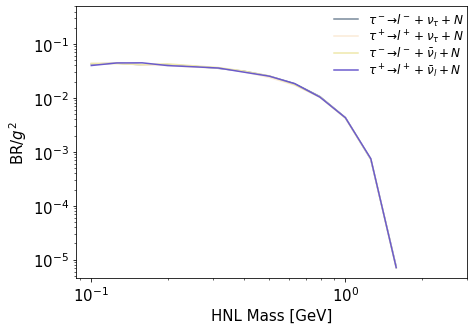

In [16]:
masses = np.logspace(-1,1,20+1)
'''productions = [
    ["2body_411_-11"     , "firebrick"   , r"$D^+ \to e^+ N$"   ],   
    ["2body_431_-11"     , "red"         , r"$D_s^+ \to e^+ N$" ],   
    ["2body_521_-11"     , "orange"      , r"$B^+ \to e^+ N$"   ],  
    ["2body_541_-11"     , "gold"        , r"$B_c^+ \to e^+ N$" ],   
    ["3body_411_-311_-11", "blue"        , r"$D^+ \to \bar{K}^0 e^+ N$" ],   
    ["3body_421_-321_-11", "deepskyblue" , r"$D^0 \to K^- e^+ N$"       ], 
    ["3body_511_-411_-11", "green"       , r"$B^0 \to D^- e^+ N$"       ], 
    ["3body_531_-431_-11", "limegreen"   , r"$B_s^+ \to D_s^- e^+ N$"   ], 
]


productions = [
['3body_vector_421_-323_-11',"red"         ,r"$D^0 \to K^{*-} + l^+ + N$"      ],
['3body_vector_521_-423_-11',"red"         ,r"$B^+ \to \bar{D}^{*0} + l^+ + N$"],
['3body_vector_511_-413_-11',"red"         ,r"$B^0 \to D^{*-} + l^+ + N$"      ],
['3body_vector_531_-433_-11',"red"         ,r"$B^0_s \to D^{*-}_s + l^+ + N$" ],
['3body_vector_541_513_-11',"red"          ,r"$B^+_c \to B^{*0} + l^+ + N$"    ],
['3body_vector_541_533_-11',"red"          ,r"$B^+_c \to B^{*0}_s+ l^+ + N$"  ]
]

productions=[["3body_tau_15_11_18" , "red" , r"$\tau^- \to l^- + \nu_{\tau} + N$"],
["3body_tau_15_11_12" , "red" , r"$\tau^- \to l^- + \bar{\nu}_l + N$"]]'''

productions_2body=[
["2body_411_-11", "mediumorchid", r"$D^+ \to l^+ + N$"],
["2body_411_-15", "lightcoral", r"$D^+ \to l^+ + N$"],
["2body_-411_11", "darkgray", r"$D^- \to l^- + N$"],
["2body_-411_15", "darkgray", r"$D^- \to l^- + N$"],
["2body_431_-11", "tan", r"$D_s^+ \to l^+ + N$"],
["2body_431_-15", "darkblue", r"$D_s^+ \to l^+ + N$"],
["2body_-431_11", "slategrey", r"$D_s^- \to l^- + N$"],
["2body_-431_15", "aqua", r"$D_s^- \to l^- + N$"],
["2body_521_-11", "paleturquoise", r"$B^+ \to + l^+ + N$"],
["2body_521_-15", "lightcyan", r"$B^+ \to + l^+ + N$"],
["2body_-521_11", "slategray", r"$B^- \to + l^- + N$"],
["2body_-521_15", "mistyrose", r"$B^- \to + l^- + N$"],
["2body_541_-11", "olivedrab", r"$B_c^+ \to + l^+ + N$"],
["2body_541_-15", "darkgoldenrod", r"$B_c^+ \to + l^+ + N$"],
["2body_-541_11", "lightyellow", r"$B_c^- \to + l^- + N$"],
["2body_-541_15", "olivedrab", r"$B_c^- \to + l^- + N$"]
]

productions_2body_tau=[
["2body_tau_15_-211", "pink", r"$\tau^- \to \pi^- + N$"],
["2body_tau_15_211", "blueviolet", r"$\tau^+ \to \pi^+ + N$"],
["2body_tau_15_-321", "darkslategray", r"$\tau^- \to K^- + N$"],
["2body_tau_15_321", "gainsboro", r"$\tau^+ \to K^+ + N$"],
["2body_tau_15_-213", "lightblue", r"$\tau^- \to \rho^- + N$"],
["2body_tau_15_213", "moccasin", r"$\tau^+ \to \rho^+ + N$"]
]

productions_3body_pseudo=[
["3body_pseudo_421_-321_-11", "darkorange", r"$D^0 \to K^- + l^+ + N$"],
["3body_pseudo_421_321_11", "lavenderblush", r"$D^0 \to K^+ + l^- + N$"],
["3body_pseudo_411_-311_-11", "khaki", r"$D^+ \to \bar{K}^0 + l^+ + N$"],
["3body_pseudo_-411_-311_11", "deepskyblue", r"$D^- \to \bar{K}^0 + l^- + N$"],
["3body_pseudo_521_421_-11", "lawngreen", r"$B^+ \to \bar{D}^0 + l^+ + N$"],
["3body_pseudo_521_421_-15", "forestgreen", r"$B^+ \to \bar{D}^0 + l^+ + N$"],
["3body_pseudo_-521_421_11", "paleturquoise", r"$B^- \to \bar{D}^0 + l^- + N$"],
["3body_pseudo_-521_421_15", "darkkhaki", r"$B^- \to \bar{D}^0 + l^- + N$"],
["3body_pseudo_511_-411_-11", "ghostwhite", r"$B^0 \to D^- + l^+ + N$"],
["3body_pseudo_511_-411_-15", "snow", r"$B^0 \to D^- + l^+ + N$"],
["3body_pseudo_511_411_11", "black", r"$B^0 \to D^+ + l^- + N$"],
["3body_pseudo_511_411_15", "mediumturquoise", r"$B^0 \to D^+ + l^- + N$"],
["3body_pseudo_531_-431_-11", "lightsteelblue", r"$B^0_s \to D^-_s + l^+ + N$"],
["3body_pseudo_531_-431_-15", "greenyellow", r"$B^0_s \to D^-_s + l^+ + N$"],
["3body_pseudo_531_431_11", "darkslategrey", r"$B^0_s \to D^+_s + l^- + N$"],
["3body_pseudo_531_431_15", "lemonchiffon", r"$B^0_s \to D^+_s + l^- + N$"],
["3body_pseudo_541_511_-11", "lightcyan", r"$B^+_c \to B^0 + l^+ + N$"],
["3body_pseudo_-541_511_11", "yellowgreen", r"$B^-_c \to B^0 + l^- + N$"],
["3body_pseudo_541_531_-11", "chocolate", r"$B^+_c \to B^0_s + l^+ + N$"],
["3body_pseudo_-541_531_11", "yellow", r"$B^-_c \to B^0_s + l^- + N$"]
]

productions_3body_vector=[
["3body_vector_421_-323_-11", "darkslateblue", r"$D^0 \to K^{*-} + l^+ + N$"],
["3body_vector_421_-323_-15", "darkslategrey", r"$D^0 \to K^{*-} + l^+ + N$"],
["3body_vector_421_323_11", "darkseagreen", r"$D^0 \to K^{*} + l^- + N$"],
["3body_vector_421_323_15", "darkseagreen", r"$D^0 \to K^{*} + l^- + N$"],
["3body_vector_521_-423_-11", "cadetblue", r"$B^+ \to \bar{D}^*0 + l^+ + N$"],
["3body_vector_521_-423_-15", "lightseagreen", r"$B^+ \to \bar{D}^*0 + l^+ + N$"],
["3body_vector_-521_-423_11", "lightsalmon", r"$B^- \to \bar{D}^*0 + l^- + N$"],
["3body_vector_-521_-423_15", "snow", r"$B^- \to \bar{D}^*0 + l^- + N$"],
["3body_vector_511_-413_-11", "orchid", r"$B^0 \to D^{*-} + l^+ + N$"],
["3body_vector_511_-413_-15", "lightblue", r"$B^0 \to D^{*-} + l^+ + N$"],
["3body_vector_511_413_11", "lightgreen", r"$B^0 \to D^{*+} + l^- + N$"],
["3body_vector_511_413_15", "papayawhip", r"$B^0 \to D^{*+} + l^- + N$"],
["3body_vector_531_-433_-11", "darkgoldenrod", r"$B^0_s \to D^{*-}_s + l^+ + N$"],
["3body_vector_531_-433_-15", "mediumaquamarine", r"$B^0_s \to D^{*-}_s + l^+ + N$"],
["3body_vector_531_433_11", "darkkhaki", r"$B^0_s \to D^{*+}_s + l^- + N$"],
["3body_vector_531_433_15", "darkslateblue", r"$B^0_s \to D^{*+}_s + l^- + N$"],
["3body_vector_541_513_-11", "lightseagreen", r"$B^+_c \to B^{*0} + l^+ + N$"],
["3body_vector_541_513_-15", "mediumturquoise", r"$B^+_c \to B^{*0} + l^+ + N$"],
["3body_vector_-541_513_11", "sandybrown", r"$B^-_c \to B^{*0} + l^- + N$"],
["3body_vector_-541_513_15", "beige", r"$B^-_c \to B^{*0} + l^- + N$"],
["3body_vector_541_533_-11", "grey", r"$B^+_c \to B^{*0}_s+ l^+ + N$"],
["3body_vector_541_533_-15", "rebeccapurple", r"$B^+_c \to B^{*0}_s+ l^+ + N$"],
["3body_vector_-541_533_11", "blue", r"$B^-_c \to B^{*0}_s+ l^- + N$"],
["3body_vector_-541_533_15", "mediumblue", r"$B^-_c \to B^{*0}_s+ l^- + N$"]
]

productions_3body_tau=[
["3body_tau_15_11_18", "lightslategray", r"$\tau^- \to l^- + \nu_{\tau} + N$"],
["3body_tau_-15_-11_18", "antiquewhite", r"$\tau^+ \to l^+ + \nu_{\tau} + N$"],
["3body_tau_15_11_12", "palegoldenrod", r"$\tau^- \to l^- + \bar{\nu}_l + N$"],
["3body_tau_-15_-11_12", "slateblue", r"$\tau^+ \to l^+ + \bar{\nu}_l + N$"]
]

foresee.plot_production_branchings(
    masses = masses, 
    productions = productions_3body_tau,
    xlims=[0,3],ylims=[0,.5], 
    xlabel=r"HNL Mass [GeV]", 
    ylabel=r"BR/$g^2$",
    legendloc=(1.02,1.02),
    fs_label=12,log_scale=True
)

plot.show()

Let's first look at one benchmark scenario with $M_{N}=1$ GeV and $\epsilon=10^{-3.5}$ using the function `foresee.get_llp_spectrum()`. By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

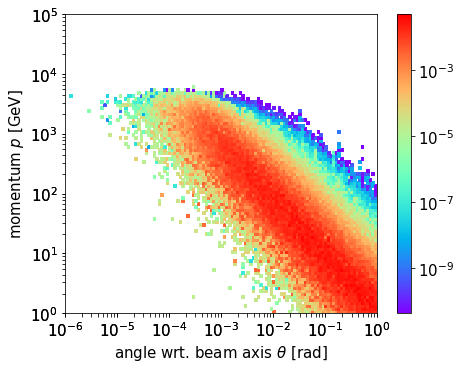

In [13]:
plot = foresee.get_llp_spectrum(mass=1., coupling=10**-3.5, do_plot=True, save_file=False)

We can now produce a set of LLP spectra for various masses  (chosen to be equally spaced in log(mass)) and unit coupling and save them. 

In [14]:
masses = np.logspace(-1,1,20+1)
masses = [1]
for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/14TeV_2body_411_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_2body_-411_11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_2body_431_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_2body_-431_11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_2body_521_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_2body_-521_11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_2body_541_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_2body_-541_11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_3body_411_-311_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_3body_-411_-311_11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_3body_421_-321_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_3body_521_421_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_3body_511_-411_-11_m_1.npy
save data to file: ./model/LLP_spectra/14TeV_3body_531_-431_-11_m_1.npy


## 4. Count Event Rate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [15]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific HNL mass $M_{N}=1$ GeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [16]:
output = foresee.get_events(mass=1, energy=energy, couplings=np.logspace(-5,0,6))
coups, ctaus, nsigs, momenta, weights = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsignal =", '{:5.3e}'.format(nsig))

epsilon = 1.000e-05 : nsignal = 8.436e-06
epsilon = 1.000e-04 : nsignal = 8.436e-02
epsilon = 1.000e-03 : nsignal = 8.418e+02
epsilon = 1.000e-02 : nsignal = 6.889e+06
epsilon = 1.000e-01 : nsignal = 1.111e+08
epsilon = 1.000e+00 : nsignal = 5.229e-43


The previous function also outputs the energy distribution of the HNL particles which decay inside the detector. Let's have a look at them.

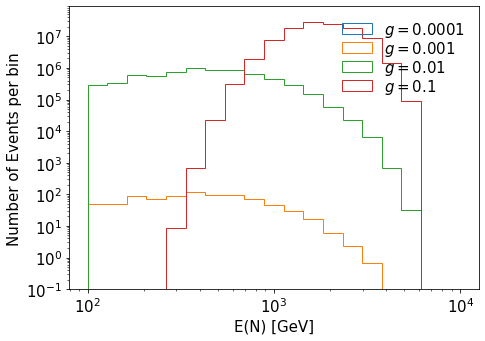

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
ens=[]
for coup,momentum,weight in zip(coups,momenta,weights):
    if sum(weight)<10**-3 : continue
    ax.hist([p.e for p in momentum],  weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$g=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-1,9*10**7) 
    ax.set_xlabel("E(N) [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

FORESEE also includes a function `write_events()` which obtains an unweighted sample of LLP decay events and saves them as a HEPMC file. For this function, we need to specify
- the `mass` and `coupling` of the LLP
- the collision `energy`
- the number of events `numberevent` that should be samples (optional, default=10)
- the `filename` of the output file (optional, default=`model/events/<mass>_<coupling>.hepmc`)
- the z-position (in meter) of the beginning of the decay volume (optional, default=0)
- a random `seed` (optional, default=None)
- the `decaychannels` for which the event should bbe written to file (optional, default=None meaning that all channels are written to file)

At the moment, FORESEE only supports 2-body LLP decays. For all other cases, including those where no final state information was specified when initiating the `Model`, the LLP will not be decayed. 

In [18]:
foresee.write_events(filename="model/events/test.hepmc", mass=1, coupling=1.000e-02, 
    energy="14", numberevent=10, zfront=0)

/Users/felixkling/Documents/GitHub/FORESEE/src/foresee.py:1037: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  channels=np.array(channels).T


Let us have a look at a the output:

In [19]:
f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)

HepMC::Version 2.06.09
HepMC::IO_GenEvent-START_EVENT_LISTING
E 0 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 251.3516300901 69.8444642807 1789.1647076574 0 1 0 0
P 1 32 0.1144909564 0.0318142338 218.6405517227 218.6428708601 1.0 1 0 0 -1 0
E 1 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -467.94974992 623.3552811867 2115.8704623416 0 1 0 0
P 1 32 -0.2028812033 0.2702577991 208.1056301169 208.1083071057 1.0 1 0 0 -1 0
E 2 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 884.0975641757 -127.6557767214 4852.3915469523 0 1 0 0
P 1 32 0.545374419 -0.0787471857 296.0982268377 296.1004281841 1.0 1 0 0 -1 0
E 3 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -303.604467263 -106.847827549 2196.6419808459 0 1 0 0
P 1 32 -0.3332660534 -0.1172866596 526.8950983414 526.8961657467 1.0 1 0 0 -1 0
E 4 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U 

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 reach for dark photons for 3 scenarios. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

- the nominal/default setup

In [30]:
#masses
masses = np.logspace(-1,1,20+1)

#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ = foresee.get_events(mass=mass, energy=energy,couplings=np.logspace(-5,0,50+1))
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [31]:
setups = [
    ["14TeV_default.npy",    "default"  , "red",     "solid", 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

In [32]:
bounds = [ 
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [33]:
projections = [
    ["limits_SHiP_el.txt",      "dodgerblue" , "SHiP"      , 3   , 0.0001 , 0  ],
    ["limits_NA62_el.txt",      "blue"       , "NA62"      , 1   , 0.0002 , 0  ],
    ["limits_DUNE_el.txt",      "cyan"       , "DUNE"      , 0.6 , 0.00009, 0  ],
    ['limits_CODEX_el.txt',     "purple"     , "CODEX"     , 2e-1, 0.0003 , 0  ],
    ["limits_MATHUSLA_el.txt",  "deepskyblue", "MATHUSLA"  , 0.3 , 0.0001 , 0  ],
    ["limits_FASER2_el.txt",    "magenta"    , "FASER2 OLD", 0.3 , 0.001  , 0  ]
]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

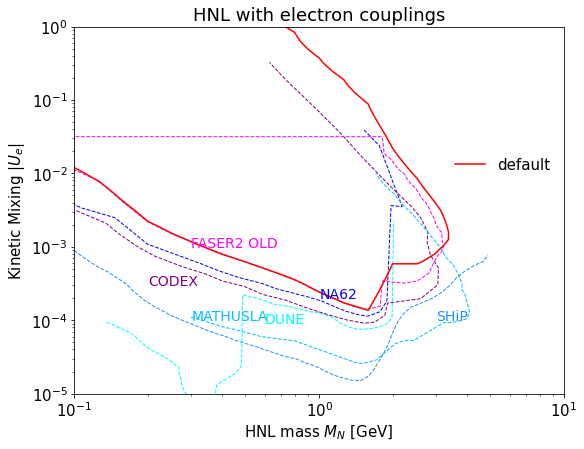

In [34]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="HNL with Electron Couplings",
    xlims = [1e-1, 10], 
    ylims = [1e-5, 1 ],
    xlabel=r"HNL mass $M_{N}$ [GeV]", 
    ylabel=r"Kinetic Mixing $|U_{e}|$",
    legendloc=(1,0.68),
    figsize=(8,6),
)
plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
#plot.savefig("/Users/alechewitt/Desktop/Figure.pdf")
plot.show()

$\color{red}{\text{      ... THE OLD (MAGENTA) and NEW (RED) LINES LOOK SIMILAR}}$
$\color{red}{\text{      ... THE DIFFERENCED RE PROABLY DUE TO DIFFERENT CHARM PRODUCTION AND MISSING PROD. CHANNELS}}$

## 7. Export Contours

It might also be useful to extract the contours lines, and save them as a text file. This can be done using the `extract_contours()` function. As example, let us export the FASER2 line. 

In [ ]:
foresee.extract_contours(
    inputfile="model/results/14TeV_default.npy", 
    outputfile="model/lines/limits_FASER2.txt"
)

## Plot Production Cross Section 

We also can plot the production cross section as a function of the particle mass via `foresee.plot_production`. We do this below to show the production rate associated with different channels (commenting out the subleading channels): 

In [ ]:
masses = [0.1, 0.2, 0.3, 0.7, 1, 1.2, 1.4, 2, 3 ]
productions = [
    ["2body_411_-11"     , None      , "firebrick"   , r"$D^+ \to e^+ N$"   ],   
    ["2body_431_-11"     , None      , "red"         , r"$D_s^+ \to e^+ N$" ],   
    ["2body_521_-11"     , [0.5,10]  , "orange"      , r"$B^+ \to e^+ N$"   ],  
    ["2body_541_-11"     , [0.5,10]  , "gold"        , r"$B_c^+ \to e^+ N$" ],   
    ["3body_411_-311_-11", None      , "blue"        , r"$D^+ \to \bar{K}^0 e^+ N$" ],   
    ["3body_421_-321_-11", None      , "deepskyblue" , r"$D^0 \to K^- e^+ N$"       ], 
    ["3body_511_-411_-11", [0.5,10]  , "green"       , r"$B^0 \to D^- e^+ N$"       ], 
    ["3body_531_-431_-11", [0.5,10]  , "limegreen"   , r"$B_s^+ \to D_s^- e^+ N$"   ], 
]

foresee.plot_production(
    masses = masses, 
    productions = productions,
    condition="True", 
    xlims=[0.1,30],ylims=[10**0,10**10], 
    xlabel=r"HNL Mass [GeV]", 
    ylabel=r"Production Rate $\sigma/\epsilon^2$ [pb]",
    legendloc=(1.02,1.02),
    fs_label=12,
    title="All HNLs",
)

plot.savefig("Figure_HNL_Prod_All.pdf")
plot.show()

In [8]:
#HNL decays 2 body decays
#pid1 is the meson pid2 is the smaller particle either lepton or neutrino
#from HNL_decays_1
#fH is called the decay constant
self=model
SecToGev=1./(6.582122*pow(10.,-25.))
pid1="111"
tauN=10**-5*SecToGev
GF=1.166378*10**(-5) #GeV^(-2)
coupling=1
mass=1
pid1="111"
pid2="12" #electron neutrino
br_pi_nu=f"tauN*(coupling**2*GF**2*hnl.fH(pid1)**2*mass**3/(32*np.pi))*(1-self.masses(pid1)**2/mass**2)**2"
print(eval(br_pi_nu))
pid1="411"
pid2="11"
br_H_l=f"(tauN*coupling**2*GF**2*hnl.VH(pid1)**2*hnl.fH(pid1)**2*mass**3/(32*np.pi))*((1-self.masses(pid2)**2/mass**2)**2-(self.masses(pid1)**2/mass**2)*(1+self.masses(pid2)**2/mass**2))*np.sqrt((1-((self.masses(pid1)-self.masses(pid2))**2/mass**2))*(1-((self.masses(pid1)+self.masses(pid2))**2/mass**2)))"
print(eval(br_H_l))
pid1="221"
pid2="12"
br_eta_nu=f"(tauN*coupling**2*GF**2*hnl.fH(pid1)**2*mass**3/(32*np.pi))*(1-self.masses(pid1)**2/mass**2)**2"
print(eval(br_eta_nu))
pid1="331"
pid2="12"
br_etap_nu=f"(tauN*coupling**2*GF**2*hnl.fH(pid1)**2*mass**3/(32*np.pi))*(1-self.masses(pid1)**2/mass**2)**2"
print(eval(br_etap_nu))
pid1="213"
pid2="11"
grho=0.102 #check this?
br_rho_l=f"(tauN*coupling**2*grho**2*GF**2*hnl.VH(pid1)**2*mass**3/(8*np.pi))*((1-self.masses(pid2)**2/mass**2)**2+(self.masses(pid1)**2/mass**2)*(1+((self.masses(pid2)**2-2*self.masses(pid1)**2)/mass**2))*np.sqrt((1-((self.masses(pid1)-self.masses(pid2))**2/mass**2))*(1-((self.masses(pid1)+self.masses(pid2))**2/mass**2))))"
print(eval(br_rho_l))
pid1="113"
pid2="12"
br_rho0_nu=f"(tauN*coupling**2*grho**2*GF**2*mass**3/(16*np.pi*self.masses(pid1)**2))*(1+2*self.masses(pid1)**2/mass**2)*(1-self.masses(pid1)**2/mass**2)**2"
print(eval(br_rho0_nu))


334906.4431206457
-309843.72139511176
245057.81202642337
480.7162747587744
771783.0450189715
249071.01901309317


In [ ]:
#this portion will take a branching fraction and write to a file in the form m br
#takes a number and chops off part of it according to the precision, or delta
def chop(expr, delta=10**-2):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)
#for the decays of HNL, takes a branching ratio and creates a file of mass br
SecToGev=1./(6.582122*pow(10.,-25.))
#tautau=self.tau(pid0)*SecToGev
tau=10**-15
tau=tau*SecToGev
GF=1.166378*10**(-5) #GeV^(-2)
pid1='111'
self=model
fH=self.fH(pid1)
br=f"(tau*coupling**2/(32*np.pi))*GF**2*fH**2*mass**3*(1-{self.masses(pid1)}**2/mass**2)**2"
coupling=1
#print(eval(br))
#print(self.fH(pid1))
def write_m_br_file(br,filename="model/br/pi_nu.txt"):
    f = open(filename, "w+")
    f.close()
    f = open(filename, "a")
    mass=1
    mass=.01
    delm=.01
    steps=int(10/.01)-1
    for n in range(steps):
        #f.write(f"{m}  {br}\n")
        #print(eval(br))
        f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,eval(br)]))
        mass=chop(mass+delm)
    f.close()
    print('file created...')
    #a=.0134155

write_m_br_file(br)